<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/algo_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman-bardo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 10.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import math
from pykalman import KalmanFilter
from matplotlib import pyplot as plt

In [2]:
# Set last day of in-sample period as Dec 31st 2016
in_sample_last = '2016-12-31'
in_sample_last_minus_half_year = '2016-07-01'

# Read S&P 500 VIX Futures close price
vx = pd.read_csv('S&P 500 VIX Futures Data.csv', index_col=0)
vx.index = pd.to_datetime(vx.index)
vx = vx.iloc[::-1]
vx_close = vx['Price']

# Read S&P 500 Futures close price
sp = pd.read_csv('S&P 500 Futures Data.csv', index_col=0)
sp.index = pd.to_datetime(sp.index)
sp = sp.iloc[::-1]
for idx, value in sp.iterrows():
    sp['Price'][idx] = value['Price'].replace(',', '')
sp_close = sp['Price']
sp_close = sp_close.astype('float64')

# Concatenate to form close price dataframe 'close_df'
close_df = pd.concat([vx_close, sp_close], axis=1)
close_df.columns = ['vx_close', 'sp_close']
close_df = close_df.interpolate(method='linear')
vx_close = close_df['vx_close']
sp_close = close_df['sp_close']

# Calculate daily return for S&P 500 VIX Futures using close price
vx_return = close_df['vx_close'].pct_change()
vx_return = vx_return.dropna()
vx_return.name = "vx_return"

# Calculate daily return for S&P 500 Futures using close price
sp_return = close_df['sp_close'].pct_change()
sp_return = sp_return.dropna()
sp_return.name = "sp_return"

# Create in-sample dataframe for close prices and returns for both VX and SP
vx_close_is = vx_close[vx_close.index <= in_sample_last]
vx_return_is = vx_return[vx_return.index <= in_sample_last]
sp_close_is = sp_close[sp_close.index <= in_sample_last]
sp_return_is = sp_return[sp_return.index <= in_sample_last]

# Create out-of-sample dataframe for close prices and returns for both VX and SP
vx_close_os = vx_close[vx_close.index > in_sample_last]
vx_return_os = vx_return[vx_return.index > in_sample_last]
sp_close_os = sp_close[sp_close.index > in_sample_last]
sp_return_os = sp_return[sp_return.index > in_sample_last]

print(vx_return_os.head())
print('')
print(sp_return_os.head())

<ipython-input-2-9084af973854>:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sp['Price'][idx] = value['Price'].replace(',', '')


data
2017-01-03   -0.084758
2017-01-04   -0.077821
2017-01-05   -0.015190
2017-01-06   -0.029991
2017-01-09    0.021201
Name: vx_return, dtype: float64

data
2017-01-03    0.008487
2017-01-04    0.005722
2017-01-05   -0.000771
2017-01-06    0.003517
2017-01-09   -0.003549
Name: sp_return, dtype: float64


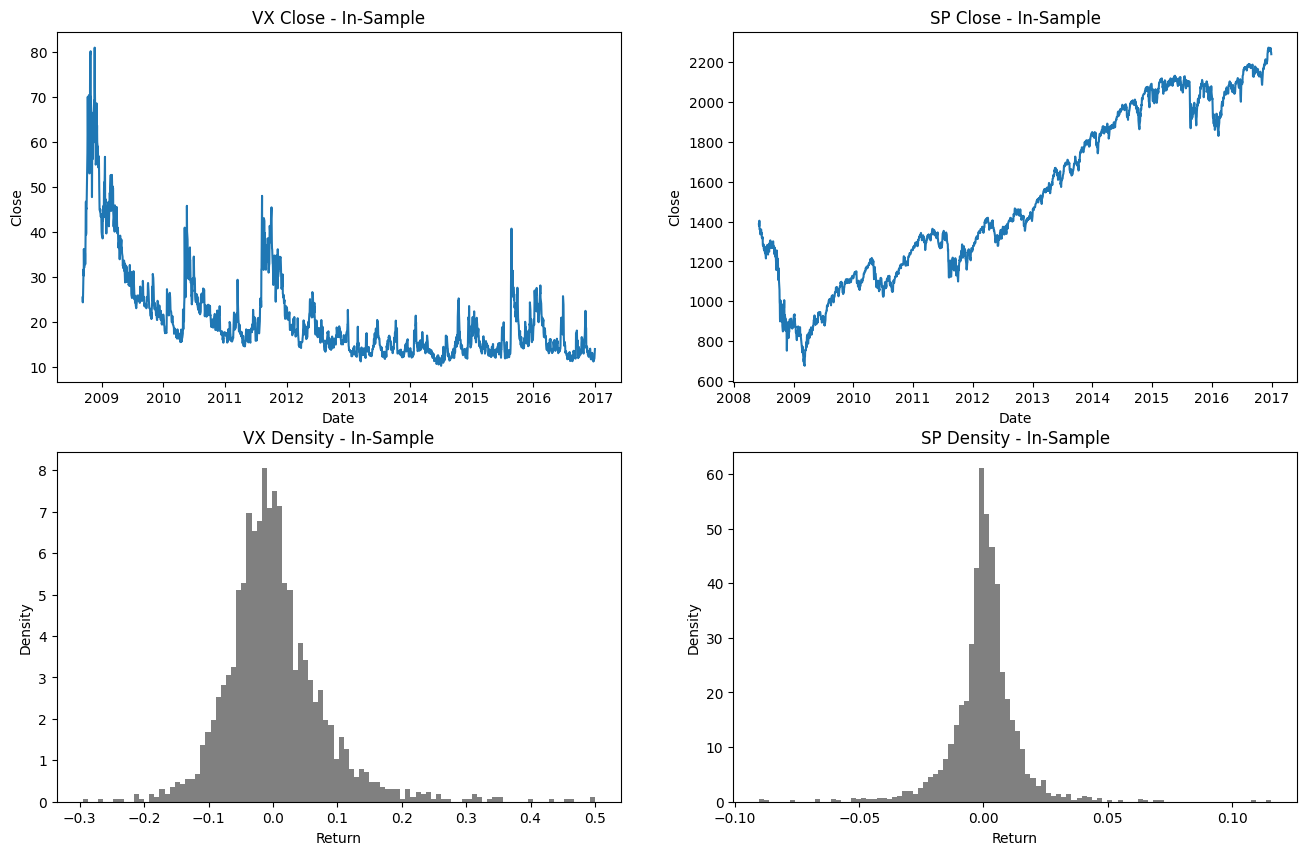

In [5]:
fig_1 = plt.figure(1, figsize=(16, 10))

#Plotting VX close prices for in-sample period
chart1 = fig_1.add_subplot(221)
chart1.plot(vx_close_is)
chart1.set_ylabel('Close')
chart1.set_xlabel('Date')
chart1.title.set_text('VX Close - In-Sample')

#Plotting SP close prices for in-sample period
chart2 = fig_1.add_subplot(222)
chart2.plot(sp_close_is)
chart2.set_ylabel('Close')
chart2.set_xlabel('Date')
chart2.title.set_text('SP Close - In-Sample')

#Plotting distribution for VX return for in-sample period
chart3 = fig_1.add_subplot(223)
chart3.hist(vx_return_is, density='True', bins=100, label='empirical', color='grey')
chart3.set_ylabel('Density')
chart3.set_xlabel('Return')
chart3.title.set_text('VX Density - In-Sample')

#Plotting distribution for SP return for in-sample period
chart4 = fig_1.add_subplot(224)
chart4.hist(sp_return_is, density='True', bins=100, label='empirical', color='grey')
chart4.set_ylabel('Density')
chart4.set_xlabel('Return')
chart4.title.set_text('SP Density - In-Sample')

plt.show()
